In [1]:
# Clone repo if running from Colab

#!git clone https://github.com/cipher982/marketing-mix-modeling.git
#!cp marketing-mix-modeling/funcs.py funcs.py

# Setup

## Import and initialize

In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

sns.color_palette("husl")
sns.set_style('darkgrid')

import pystan
# import stan
import os
import json
import funcs

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
DATA_DIR = 'data/'
NUM_CHAINS = 12
SEED = 0

print(DATA_DIR)

data/


# Data Prep
## Load and Group Data
Load and re-format to a weekly grouping the datasets provided:
- Measured ad channels 
- Product sales
- Facebook
- TV



In [3]:
%%time

# Load measured data
m_df = pd.read_csv(DATA_DIR+"measured_ad_channel_data.csv")
m_df = m_df[m_df["channel"] != "Congrats  YOU FOUND ME!!!!"]

# extract weekly dates
m_df = funcs.add_week_start(m_df, 'day')

# get weekly media impressions
m_imp = m_df.groupby(["wk_strt_dt","channel"]).sum()['impressions'].reset_index()
m_imp = m_imp.pivot(index='wk_strt_dt', columns=['channel'], values=['impressions'])
m_imp = m_imp.droplevel(axis=1, level=0).reset_index()
m_imp = m_imp.fillna(value=0)
#m_imp.head(3)

# get weekly media spend
m_sp = m_df.groupby(["wk_strt_dt","channel"]).sum()['spend'].reset_index()
m_sp = m_sp.pivot(index='wk_strt_dt', columns=['channel'], values=['spend'])
m_sp = m_sp.droplevel(axis=1, level=0).reset_index()
m_sp = m_sp.fillna(value=0)
#m_sp.head(3)

# Get weekly sales
sales = pd.read_csv(DATA_DIR+"order_data.csv.gzip", compression="gzip")
sales['date'] = pd.to_datetime(sales['ORDER_DATE'])
sales['weekday'] = sales['date'].dt.weekday
sales["wk_strt_dt"] = sales['date'] - sales['weekday'] * timedelta(days=1)
sales = pd.DataFrame(sales.groupby(["wk_strt_dt"]).sum()['PRODUCT_SUBTOTAL'])
sales.columns = ['sales']

# Get Facebook data
fb = pd.read_csv(DATA_DIR+"collaborative_ad_data.csv")
fb = funcs.add_week_start(fb, "DATE")
fb = pd.DataFrame(fb.groupby(["wk_strt_dt"])['SPEND','IMPRESSIONS'].sum())
fb.columns = ['Facebook_spnd','Facebook_imps']

# Get TV data
tv = pd.read_csv(DATA_DIR+"tv_spend.csv")
tv.fillna(0, inplace=True)
tv = funcs.add_week_start(tv, 'date')
tv['tv_imps'] = tv['spend'] / tv['cost per view']
tv = pd.DataFrame(tv.groupby(['wk_strt_dt'])['tv_imps','spend'].sum())
tv.columns = ['tv_imps', 'tv_spnd']

# Create holiday data
dr = pd.date_range(start=sales.index.min(), end=sales.index.max())
hldy_df = pd.DataFrame()
hldy_df['date'] = dr

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
hldy_df['holiday'] = hldy_df['date'].isin(holidays)

hldy_df = funcs.add_week_start(hldy_df, 'date')
hldy_df = pd.DataFrame(hldy_df.groupby(["wk_strt_dt"]).any()['holiday'])
hldy_df = hldy_df.astype(int)
print("Loaded all datasets.")

Loaded all datasets.
CPU times: user 1.77 s, sys: 152 ms, total: 1.92 s
Wall time: 1.92 s


## Combine Data

Merge the datasets together for a master df. Also add in control data for holidays.

In [25]:
%%time

# Merge all data
df = pd.merge(m_imp, m_sp, on='wk_strt_dt', suffixes=('_imps','_spnd'))
df = pd.merge(df, hldy_df, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, sales, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, fb, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, tv, left_on='wk_strt_dt', right_index=True, how='left')

# set placeholder for seasonality
df['seasonality'] = 1.0 

# ensure no 0s in the data (bugs like them)
df.fillna(value=0.0, inplace=True)
df = df.replace(to_replace=0.0, value=10.0) 

# mean-centralize: sales, numeric base_vars
hldy_cols = ['holiday']
seas_cols = ['seasonality']
me_cols = []
st_cols = []
mrkdn_cols = []

df_ctrl, sc_ctrl = funcs.mean_center_transform(
    df=df, 
    cols=['sales']+me_cols+st_cols+mrkdn_cols
)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

# variables with pos effect on sales: economy, num_stores, sales, holiday
pos_vars = ['holiday']
X1 = df_ctrl[pos_vars].values

# variables may have either pos or neg impact on sales: seasonality
pn_vars = [seas_cols[0]]
X2 = df_ctrl[pn_vars].values

CPU times: user 12.3 ms, sys: 357 µs, total: 12.7 ms
Wall time: 11.1 ms


# Explore Data
## Plot

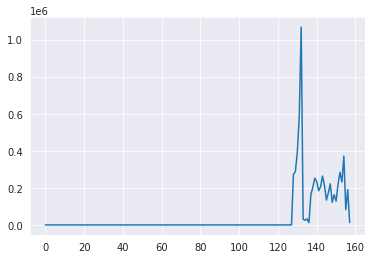

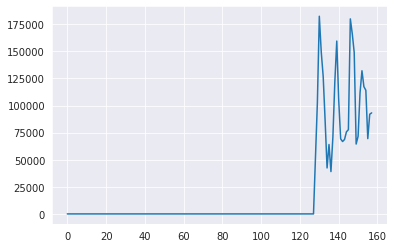

In [62]:
plt.plot(df['tv_imps'])
plt.show()
plt.plot(df['tv_spnd'])
plt.show()

# Modeling

## STAN Model (control)

Create our first simple STAN model based off just the control data

In [26]:
%%time

ctrl_data = {
    'N': len(df_ctrl), # dataset
    'K1': len(pos_vars), # len of positive only features
    'K2': len(pn_vars), # len of pos or neg features
    'X1': X1, # positive features values
    'X2': X2, # pos or neg features values
    'y': df_ctrl['sales'].values, # sales as label
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''
sm1 = pystan.StanModel(model_code=ctrl_code1)
fit1 = sm1.sampling(data=ctrl_data, iter=1000, chains=NUM_CHAINS)
fit1_result = fit1.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_548939bc33801f8115bc26206558c913 NOW.


CPU times: user 756 ms, sys: 89.4 ms, total: 845 ms
Wall time: 36.5 s


In [27]:
%%time

# Extract the model values
base_sales_model = funcs.extract_ctrl_model(
    fit1_result, 
    pos_vars=pos_vars, 
    pn_vars=pn_vars
)

# Predict the base sales
base_sales = funcs.ctrl_model_predict(base_sales_model, df_ctrl)

# Append back to the DF
df['base_sales'] = base_sales*sc_ctrl['sales']

# Evaluate the model
mape = funcs.mean_absolute_percentage_error(df['sales'], df['base_sales'])
print(f"mape: {mape:.2f}")

mape: 126.16
CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 2.36 ms


## MMM based on impressions

In [35]:
%%time

# Declare columns to use
mdip_cols = [col for col in df.columns if '_imp' in col]
mdip_cols

df_mmm, sc_mmm = funcs.mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
mu_mdip[1] = 100

max_lag = 8
num_media = len(mdip_cols)

# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_media = np.nan_to_num(X_media)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  int<lower=1> N; // samples count
  real y[N]; // sales vector
  int<lower=1> max_lag; // max duration of lag effect (weeks)
  int<lower=1> num_media;   // media channels count
  matrix[N+max_lag-1, num_media] X_media; // matrix of media variables
  real mu_mdip[num_media];   // vector of media variables' mean
  int<lower=1> num_ctrl;   // control variables count
  matrix[N, num_ctrl] X_ctrl;   // matrix of control variables
}

parameters {
NUM_CHAINSlower=0> noise_var;   // residual variance
  real tau;   // intercept
  vector<lower=0>[num_media+num_ctrl] beta;   // coefficients for media base sales
  vector<lower=0,upper=1>[num_media] decay; // decays for adstrock transforms
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak; // peaks for adstock transforms
}

transformed parameters {
  real cum_effect;   // cumulative media effect after adstock
  matrix[N, num_media] X_media_adstocked;   // matrix of media variables after adstock
  matrix[N, num_media+num_ctrl] X;   // matrix of all predictors
  row_vector[max_lag] lag_weights;   // adstock, mean-center, log1p transformation
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''
print("Loading StanModel. . .")
try:
    sm2
except:
    sm2 = pystan.StanModel(model_code=model_code2)
print("Beginning sampling. . .")
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=NUM_CHAINS)
fit2_result = fit2.extract()

Loading StanModel. . .
Beginning sampling. . .


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 1.32 s, sys: 888 ms, total: 2.21 s
Wall time: 10min 29s


In [74]:
model_data2.keys()

dict_keys(['N', 'max_lag', 'num_media', 'X_media', 'mu_mdip', 'num_ctrl', 'X_ctrl', 'y'])

CPU times: user 1.92 s, sys: 981 ms, total: 2.9 s
Wall time: 812 ms


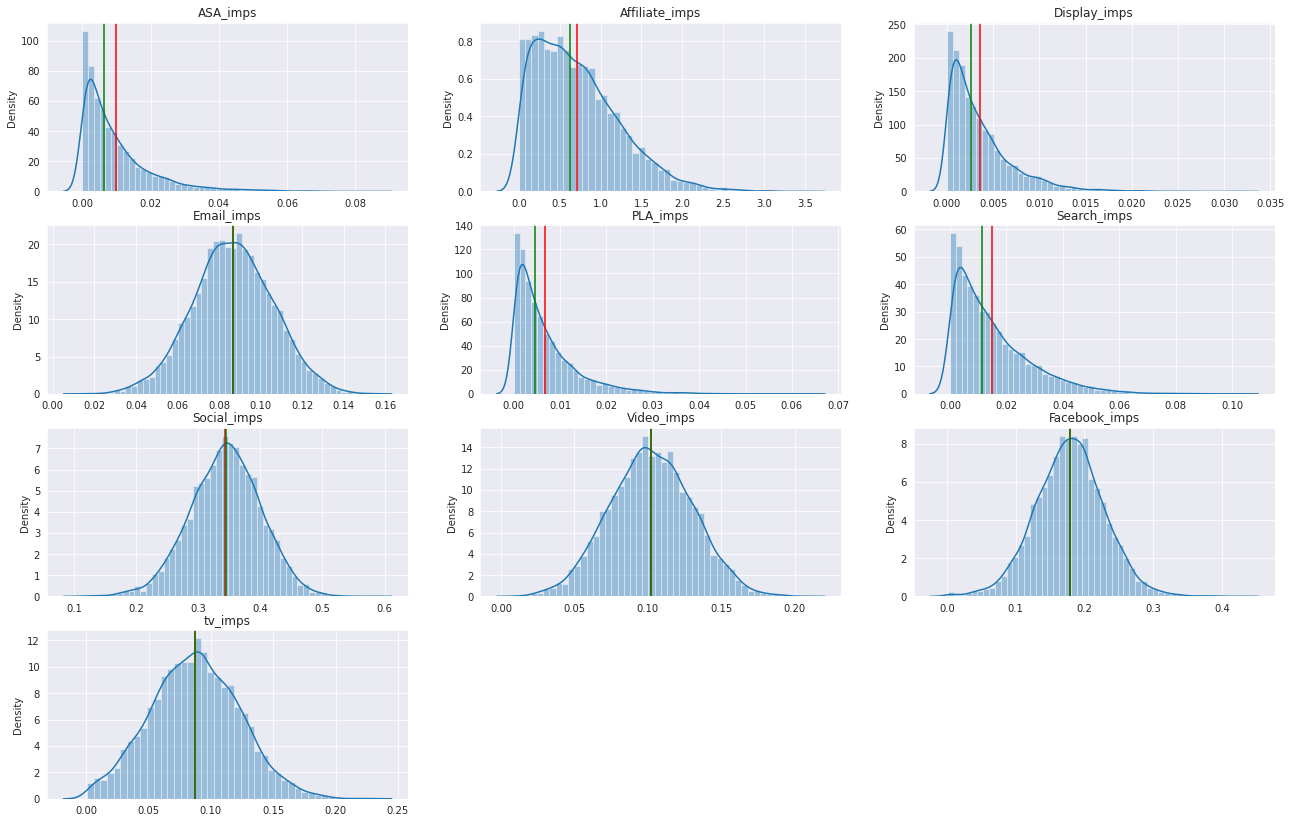

In [36]:
%%time

# Extract the model values
mmm = funcs.extract_mmm(
    fit2, 
    max_lag=max_lag, 
    media_vars=mdip_cols, 
    ctrl_vars=['base_sales']
)

# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(22,18))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

In [38]:
# decompose sales to media contribution
mc_df = funcs.mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']

# calculate media contribution percentage
mc_pct, mc_pct2 = funcs.calc_media_contrib_pct(mc_df, mdip_cols, 'sales', period=52)

rmse (log-log model):  0.45372405090843443
mape (multiplicative model):  87.11347076505115


In [77]:
%%time

model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  // the total number of observations
  int<lower=1> N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}

parameters {
  // residual variance
  real<lower=0> noise_var;
  // regression coefficient
  real<lower=0> beta_hill;
  // ec50 and slope for Hill function of the media
  real<lower=0,upper=1> ec;
  real<lower=0> slope;
}

transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''
# train hill models for all media channels
try:
    sm3
except NameError:
    sm3 = pystan.StanModel(model_code=model_code3)
hill_models = {}
to_train = ['ASA', 'Affiliate', 'Display', 'Email', 'PLA',
            'Search', 'Social', 'Video', 'Facebook', 'tv']
for media in to_train:
    print('training for media: ', media)
    hill_model = funcs.train_hill_model(df, mc_df, adstock_params, media, sm3, NUM_CHAINS)
    print("trained for media: ", media)
    hill_models[media] = hill_model

# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    print("extracting " + md)
    hill_model = hill_models[md]
    params1 = funcs.extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2

# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = funcs.evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)



training for media:  ASA
create_ media: ASA
Data shape: (158,)
Begin sampling. . .
Finished sampling!
trained for media:  ASA
training for media:  Affiliate
create_ media: Affiliate
Data shape: (158,)
Begin sampling. . .
Finished sampling!
trained for media:  Affiliate
training for media:  Display
create_ media: Display
Data shape: (158,)
Begin sampling. . .
Finished sampling!
trained for media:  Display
training for media:  Email
create_ media: Email
Data shape: (158,)
Begin sampling. . .
Finished sampling!
trained for media:  Email
training for media:  PLA
create_ media: PLA
Data shape: (158,)
Begin sampling. . .
Finished sampling!
trained for media:  PLA
training for media:  Search
create_ media: Search
Data shape: (158,)
Begin sampling. . .
Finished sampling!
trained for media:  Search
training for media:  Social
create_ media: Social
Data shape: (158,)
Begin sampling. . .
Finished sampling!
trained for media:  Social
training for media:  Video
create_ media: Video
Data shape: (158

Calculating ROAS. . .
Calculating weekly ROAS. . .
CPU times: user 697 ms, sys: 262 ms, total: 959 ms
Wall time: 349 ms


,roas_mean,roas_median,mroas,roas_avg
ASA,4.998934,4.848925,0.550615,4.791597
Affiliate,240.658464,272.124919,41.489724,168.387069
Display,0.147213,0.146780,0.405542,0.147213
Email,8.827869,3.358486,3060.961172,8.827869
PLA,5.641972,5.830920,1.037908,4.623883
Search,0.602070,0.495695,0.151526,0.608916
Social,4.790246,4.686489,0.823340,4.559487
Video,12.039230,3.778031,0.911215,19.562451
Facebook,1.889997,1.684685,0.468322,1.562607
tv,8.991378,8.866438,0.630509,7.616935


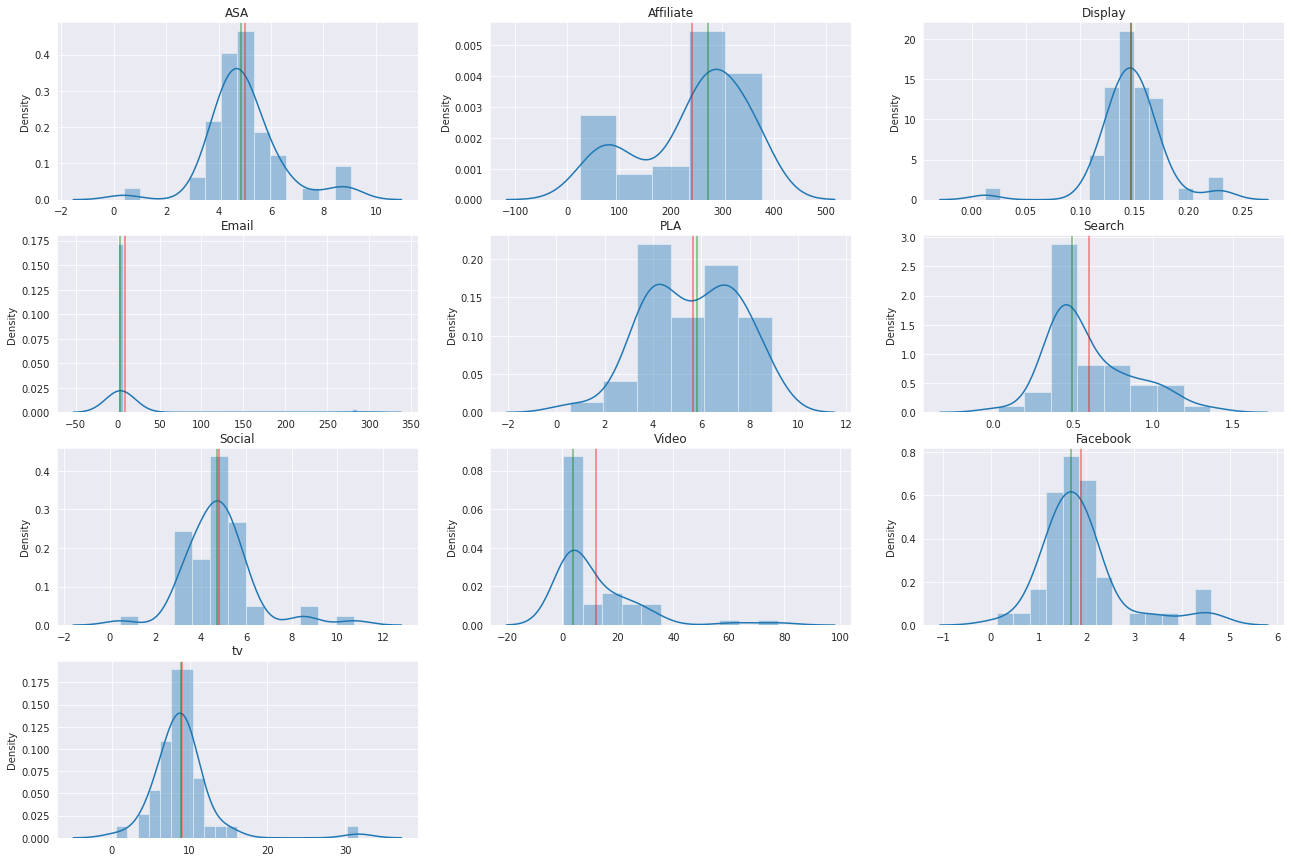

In [79]:
%%time

# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    #print("md: ",md)
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df[md+"_spnd"] = x
# ms_df.to_csv('ms_df1.csv', index=False)

roas_1y = funcs.calc_roas(mc_df, ms_df, period=52)
weekly_roas = funcs.calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(22,15))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)


# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)


# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = funcs.calc_mroas(hill_model, hill_model_params, period=52)

roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df
# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   

ASA:4.89
Affiliate:272.12
Display:0.15
Email:3.36
PLA:5.83
Search:0.50
Social:4.74
Video:3.80
Facebook:1.75
tv:8.93


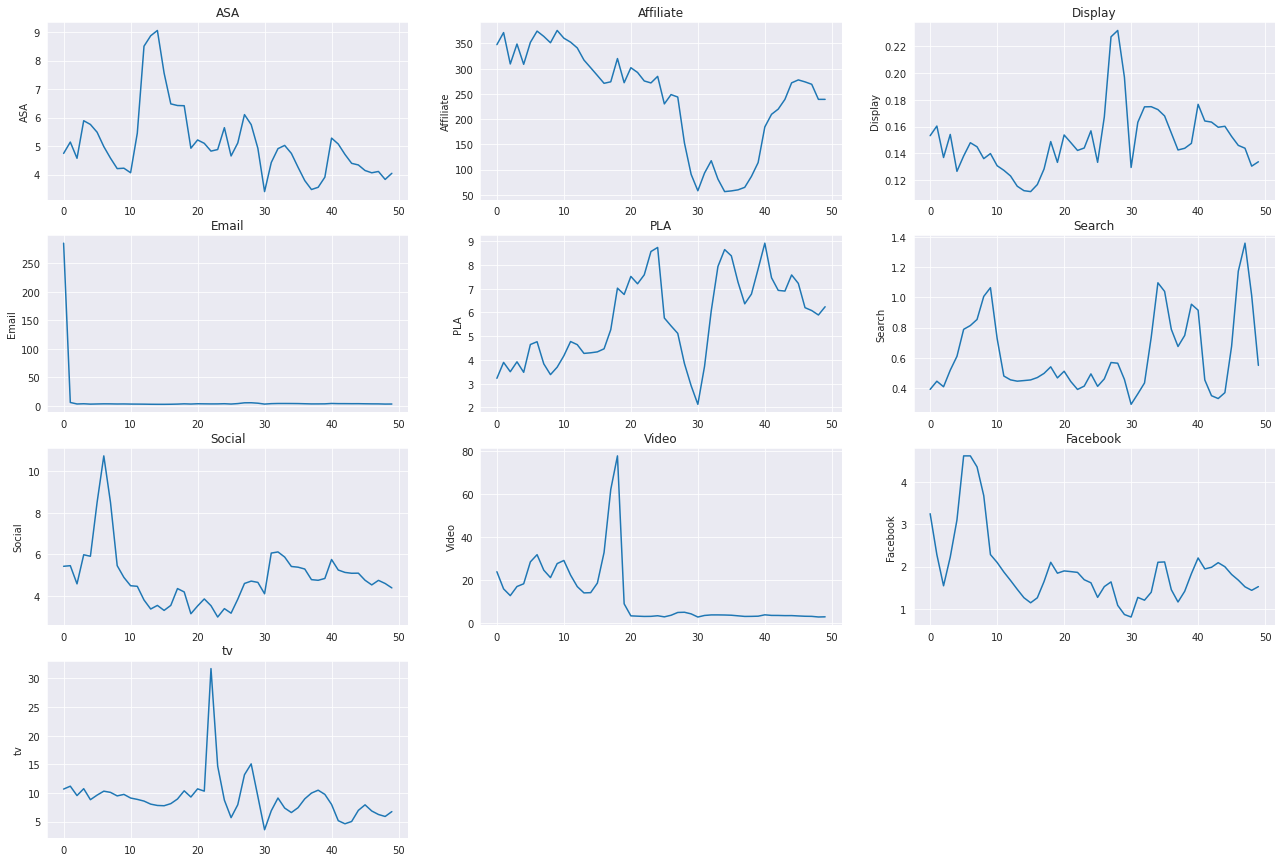

In [84]:
recent_dates = df[-52:-2]['wk_strt_dt']

f = plt.figure(figsize=(22,15))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:-2]
    print(f"{md}:{x.median():.2f}")
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.lineplot(x=list(range(0,50)),y=x)
    #ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    #ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)